In [5]:
import pandas as pd

"""
Quais foram as compras de jogadores com melhores e 
piores custo-benefício registradas?
"""

def open_csv(arquivo):
    with open('../data/'+arquivo+'.csv', 'r', encoding='latin1') as file:
        return pd.read_csv(file)
    
#Tabelas a serem utilizadas

appearances = open_csv("appearances")
game_events = open_csv("game_events")
player_valuations = open_csv("player_valuations")
players = open_csv("players")
transfers = open_csv("transfers")

#Em transfers, ordenar pelo valor
#Proxy para determinar se o jogar é bom: appearances, game_events


In [2]:
#Dropar apenas quansd tiver NaN nas colunas uteis e nao todas
appearances.dropna(axis=0, inplace=True) 
game_events.dropna(axis=0, inplace=True)
player_valuations.dropna(axis=0, inplace=True)
players.dropna(axis=0, subset=["market_value_in_eur"], inplace=True)
transfers.dropna(axis=0, subset=["market_value_in_eur"], inplace=True)

In [40]:
from datetime import date, datetime

def proxy(games_played, yellow_cards, red_cards, goals, assists, start_price, final_price):
    delta_price = final_price - start_price
    modificador = 10 ** (len(str(delta_price))-1)

    #Fórmula para calcular desempenho do jogador, segundo sites esportivos (contem modificacao)
    reduce = ( (-1)*yellow_cards + (-3)*red_cards + (8)*goals + (5)*assists ) * modificador / games_played
    return round((reduce + delta_price) / start_price, 4)
    

def parse_date(date_str: str) -> date:
    if len(date_str) > 10:
        return datetime.strptime(date_str, '%Y-%m-%d %H:%M:%S').date()
    return datetime.strptime(date_str, '%Y-%m-%d').date()


In [22]:
import os
PATH = '../data/cost_benefit.csv'

def create():
    #Criação do arquivo CSV, caso ainda não criado
    #if not os.path.exists(PATH):
        cost_benefit = pd.DataFrame({
            "player_id": [],
            "club_id": [],
            "cost_benefit": []
        })
        cost_benefit.to_csv(PATH, index=False)
        return

def add(player_id, club_id, cb):
    #Inserção de cada transferência ao CSV
    cost_benefit = pd.DataFrame({
            "player_id": [player_id],
            "club_id": [club_id],
            "cost_benefit": [cb]             
    })
    cost_benefit.to_csv(PATH, mode='a', header=False, index=False)
    return


In [41]:
#create()
    
#Para cada jogador catalogado em "players"
for player_id in players['player_id']:
    transfers_player = transfers.loc[transfers['player_id'] == player_id]
    #Se esse jogador tiver transferências em "transfers"
    if not transfers_player.empty:
        transfers_player.sort_values(by='transfer_date', ascending=True, inplace=True)
        transfers_player.reset_index(drop=True, inplace=True)
        #Para cada transferência referente a esse jogador
        for index, each_row_transfers_player in transfers_player.iterrows():
            start_date = parse_date(each_row_transfers_player['transfer_date'])
            to_club_id = each_row_transfers_player['to_club_id']
            start_price = each_row_transfers_player['market_value_in_eur']
            if index < len(transfers_player) - 1:
                final_date = parse_date(transfers_player.loc[index+1,'transfer_date'])
                final_price = transfers_player.loc[index+1,'market_value_in_eur']
            else:
                final_date = datetime.now().date()
                final_price = players.loc[players['player_id'] == player_id, 'market_value_in_eur'].values[0]
                print(final_price)
            data_parameters = {
                "games_played": 0,
                "yellow_cards": 0,
                "red_cards": 0,
                "goals": 0,
                "assists": 0,
                "start_price": start_price,
                "final_price": final_price}

            #Para cada jogo entre as datas das transfências
            appearances_player = appearances.loc[appearances['player_id'] == player_id]
            for _, each_row_appearances_player in appearances_player.iterrows():
                data = parse_date(each_row_appearances_player["date"])
                if start_date <= data and data <= final_date:
                    data_parameters["games_played"] += 1
                    data_parameters["yellow_cards"] += each_row_appearances_player["yellow_cards"]
                    data_parameters["red_cards"] += each_row_appearances_player["red_cards"]
                    data_parameters["goals"] += each_row_appearances_player["goals"]
                    data_parameters["assists"] += each_row_appearances_player["assists"]
            if data_parameters["games_played"] != 0:
                add(player_id, to_club_id, proxy(**data_parameters))




# transfers.dropna(axis=0, inplace=True)
# transfers.sort_values(by='market_value_in_eur', ascending=False, inplace=True)
# transfers

C:\Users\luizb\AppData\Local\Temp\ipykernel_9684\4189560590.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  transfers_player.sort_values(by='transfer_date', ascending=True, inplace=True)


1000000.0
50000.0
400000.0
10000000.0
600000.0
300000.0
50000.0
550000.0
100000.0
3000000.0
150000.0
100000.0
1500000.0
100000.0
500000.0
500000.0
200000.0
350000.0
1500000.0
2500000.0
500000.0
20000000.0
100000.0
1000000.0
4000000.0
1200000.0
300000.0
250000.0
50000.0
100000.0
2000000.0
1000000.0
50000.0
100000.0
100000.0
600000.0
100000.0
25000.0
600000.0
800000.0
100000.0
100000.0
50000.0
1000000.0
275000.0
150000.0
2500000.0
100000.0
100000.0
400000.0
100000.0
700000.0
200000.0
100000.0
400000.0
150000.0
6000000.0
750000.0
100000.0
2700000.0
200000.0
1000000.0
800000.0
50000.0
1000000.0
700000.0
200000.0
50000.0
1000000.0
250000.0
300000.0
300000.0
10000000.0
2500000.0
3500000.0
1000000.0
500000.0
100000.0
50000.0
400000.0
200000.0
1000000.0
200000.0
100000.0
500000.0
300000.0
250000.0
150000.0
50000.0
700000.0
1500000.0
175000.0
3500000.0
5000000.0
300000.0
800000.0
3500000.0
100000.0
200000.0
400000.0
1200000.0
75000.0
15000000.0
1400000.0
100000.0
100000.0
3500000.0
800000.0
500

In [9]:
cost_benefit = open_csv("cost_benefit")
cost_benefit.sort_values(by='cost_benefit', ascending=True, inplace=True)
cost_benefit.describe()

,player_id,club_id,cost_benefit
count,2.069500e+04,20695.000000,20695.000000
mean,3.384331e+05,4995.468181,164.324394
std,2.200875e+05,12701.960235,1319.714718
min,3.333000e+03,2.000000,-1716.000000
25%,1.684395e+05,336.000000,0.000000
50%,2.947670e+05,935.000000,4.807700
75%,4.692110e+05,2824.500000,70.981450
max,1.237998e+06,111271.000000,95801.040800


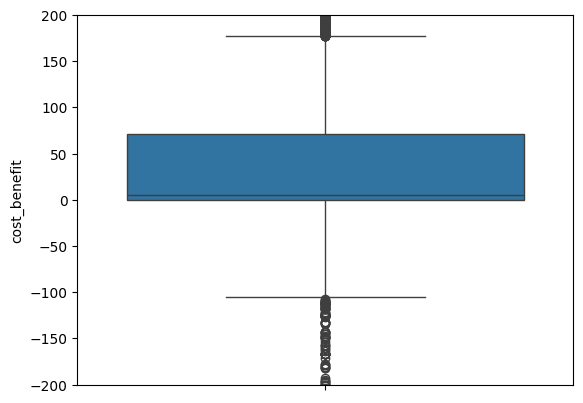

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.boxplot(data=cost_benefit, y="cost_benefit")

plt.ylim(-200, 200)
plt.show()